In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Distribusi Panjang Token

Tokenizer berhasil dimuat.
Dataset 'liputan6_dataset_train.csv' berhasil dimuat.
Jumlah artikel: 193883
Memulai proses tokenisasi untuk menghitung panjang...
Proses tokenisasi selesai.

--- Statistik Panjang Token (Train Set) ---
Panjang Token Maksimal: 8379
Panjang Token Rata-rata: 269.98
Persentase Artikel > 512 Token: 6.46%

Membuat visualisasi...


<Figure size 1200x600 with 0 Axes>

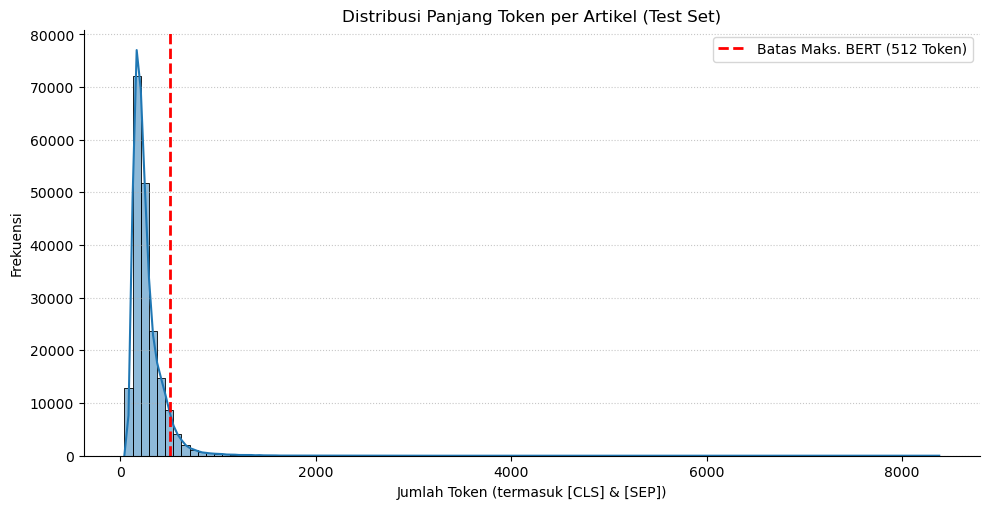

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import re

MODEL_NAME = "indobenchmark/indobert-base-p1"

# 1. Load Tokenizer  
# Ini akan mengunduh tokenizer yang sesuai dengan model IndoBERT

try:
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    print("Tokenizer berhasil dimuat.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Pastikan koneksi internet Anda stabil dan librari transformers sudah terinstal dengan benar.")
    
# 2. Load Dataset

try:
    df_train = pd.read_csv(r"E:\My Drive\Indonesia AI\2. Advanced NLP\Project 2\raw_data\liputan6_dataset_train.csv", usecols=['clean_article'])
    
    # Menghapus baris yang mungkin kosong/NaN jika ada
    df_train = df_train.dropna(subset=['clean_article'])

    print(f"Dataset 'liputan6_dataset_train.csv' berhasil dimuat.")
    print(f"Jumlah artikel: {len(df_train)}")

except FileNotFoundError:
    print("File 'liputan6_dataset_train.csv' tidak ditemukan. Pastikan path sudah benar.")
    
# 3. Fungsi untuk Tokenisasi dan Menghitung Panjang

def get_token_length(text):
    # tokenizer.encode() akan menambahkan token spesial [CLS] dan [SEP]
    # jadi kita tidak perlu menambahkannya secara manual
    return len(tokenizer.encode(text, max_length=512, truncation=False))

# 4. Terapkan Tokenisasi (jika tokenizer dan df berhasil dimuat)

if 'tokenizer' in locals() and tokenizer is not None and 'df_train' in locals() and df_train is not None:
    print("Memulai proses tokenisasi untuk menghitung panjang...")
    # Kita buat kolom baru 'token_length'
    df_train['token_length'] = df_train['clean_article'].apply(get_token_length)
    print("Proses tokenisasi selesai.")

    # 5. Analisis Statistik
    max_len = df_train['token_length'].max()
    avg_len = df_train['token_length'].mean()
    percent_over_512 = (df_train['token_length'] > 512).mean() * 100

    print(f"\n--- Statistik Panjang Token (Train Set) ---")
    print(f"Panjang Token Maksimal: {max_len}")
    print(f"Panjang Token Rata-rata: {avg_len:.2f}")
    print(f"Persentase Artikel > 512 Token: {percent_over_512:.2f}%")

    # 6. Visualisasi Distribusi
    print("\nMembuat visualisasi...")
    plt.figure(figsize=(12, 6))
    
    # Menggunakan displot untuk melihat distribusi (histogram)
    sns.displot(df_train['token_length'], kde=True, bins=100, aspect=2)
    
    # Menambahkan garis vertikal pada 512 token
    plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='Batas Maks. BERT (512 Token)')
    
    plt.title('Distribusi Panjang Token per Artikel (Test Set)')
    plt.xlabel('Jumlah Token (termasuk [CLS] & [SEP])')
    plt.ylabel('Frekuensi')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    
    # Menampilkan plot
    plt.show()

else:
    print("Tidak dapat melanjutkan analisis karena tokenizer atau file dataset gagal dimuat.")

# Check Lead Bias

In [11]:
import pandas as pd
import ast  # Modul untuk 'Abstract Syntax Trees', aman untuk parsing list
import collections
import matplotlib.pyplot as plt
import seaborn as sns

Memuat dataset 'E:\My Drive\Indonesia AI\2. Advanced NLP\Project 2\raw_data\liputan6_dataset_train.csv'... (hanya kolom 'extractive_summary')
Dataset berhasil dimuat. Total entri: 193883
Memproses indeks ringkasan...
Proses perhitungan frekuensi selesai.

--- Frekuensi 10 Indeks Kalimat Teratas ---
    Sentence Index  Frequency
0                0     100093
1                1      88999
2                2      57890
3                3      42949
5                4      32939
4                5      25315
7                6      19751
8                7      15009
12               8      11478
11               9       8707

Membuat visualisasi...
Visualisasi berhasil disimpan ke 'eda_2_lead_bias_analysis.png'


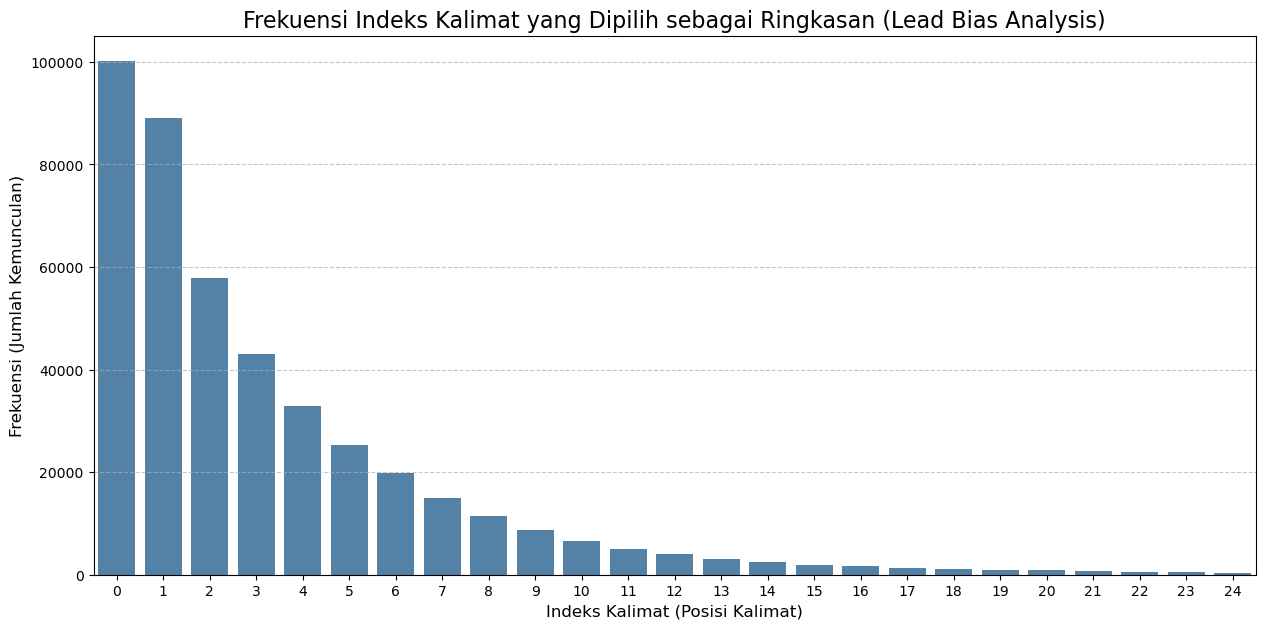

In [13]:
TRAIN_FILE = r"E:\My Drive\Indonesia AI\2. Advanced NLP\Project 2\raw_data\liputan6_dataset_train.csv"

# Kita hanya butuh kolom 'extractive_summary'
print(f"Memuat dataset '{TRAIN_FILE}'... (hanya kolom 'extractive_summary')")
try:
    # Menggunakan usecols untuk menghemat memori secara signifikan
    df_train = pd.read_csv(TRAIN_FILE, usecols=['extractive_summary'])
    
    # Menghapus baris yang mungkin NaN
    df_train = df_train.dropna(subset=['extractive_summary'])
    print(f"Dataset berhasil dimuat. Total entri: {len(df_train)}")

except FileNotFoundError:
    print(f"ERROR: File '{TRAIN_FILE}' tidak ditemukan.")
    print("Silakan pastikan file ada di direktori yang sama.")
    # Kita buat DataFrame kosong agar sisa kode tidak error,
    # meskipun tidak akan menghasilkan output.
    df_train = pd.DataFrame(columns=['extractive_summary'])
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")
    df_train = pd.DataFrame(columns=['extractive_summary'])
    
if not df_train.empty:
    # 2. Proses Pengecekan 'Lead Bias'
    print("Memproses indeks ringkasan...")
    
    # all_indices akan menyimpan SEMUA indeks dari seluruh dataset
    # misal: [0, 1, 4, 0, 2, 0, 1, 5, ...]
    all_indices = []
    
    for summary_str in df_train['extractive_summary']:
        try:
            # ast.literal_eval() aman untuk mengubah string "[0, 1, 4]"
            # menjadi list Python [0, 1, 4]
            indices = ast.literal_eval(summary_str)
            
            if isinstance(indices, list):
                all_indices.extend(indices)
        except (ValueError, SyntaxError):
            # Melewati baris yang mungkin formatnya rusak
            continue

    # 3. Hitung Frekuensi
    # Counter akan menghitung: {0: 150000, 1: 90000, 2: 45000, ...}
    index_counts = collections.Counter(all_indices)
    
    # Ubah ke DataFrame untuk plotting
    counts_df = pd.DataFrame(index_counts.items(), columns=['Sentence Index', 'Frequency'])
    counts_df = counts_df.sort_values(by='Sentence Index')

    print("Proses perhitungan frekuensi selesai.")
    print("\n--- Frekuensi 10 Indeks Kalimat Teratas ---")
    print(counts_df.head(10))

    # 4. Visualisasi
    print("\nMembuat visualisasi...")
    
    # Kita hanya akan plot 25 indeks pertama agar grafiknya mudah dibaca
    # Karena indeks setelah 25 biasanya frekuensinya sudah sangat kecil
    plot_df = counts_df[counts_df['Sentence Index'] < 25]

    plt.figure(figsize=(15, 7))
    sns.barplot(data=plot_df, x='Sentence Index', y='Frequency', color='steelblue')
    
    plt.title('Frekuensi Indeks Kalimat yang Dipilih sebagai Ringkasan (Lead Bias Analysis)', fontsize=16)
    plt.xlabel('Indeks Kalimat (Posisi Kalimat)', fontsize=12)
    plt.ylabel('Frekuensi (Jumlah Kemunculan)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Menyimpan plot ke file
    plot_filename = 'eda_2_lead_bias_analysis.png'
    plt.savefig(plot_filename)
    print(f"Visualisasi berhasil disimpan ke '{plot_filename}'")
    # plt.show() # Tampilkan plot di notebook

else:
    print("DataFrame kosong, analisis 'Lead Bias' dibatalkan.")

# Check Class Imbalance

Memuat dataset 'E:\My Drive\Indonesia AI\2. Advanced NLP\Project 2\raw_data\liputan6_dataset_train.csv'...
Dataset berhasil dimuat. Total entri: 193883
Memulai perhitungan label kalimat...
  ... telah memproses 20000 artikel
  ... telah memproses 40000 artikel
  ... telah memproses 60000 artikel
  ... telah memproses 80000 artikel
  ... telah memproses 100000 artikel
  ... telah memproses 120000 artikel
  ... telah memproses 140000 artikel
  ... telah memproses 160000 artikel
  ... telah memproses 180000 artikel
Perhitungan label selesai.

--- Statistik Keseimbangan Kelas (Level Kalimat) ---
Total Kalimat di Seluruh Dataset: 2939284
Total Kalimat Label '1' (Ringkasan):   438288
Total Kalimat Label '0' (Non-Ringkasan): 2500996
Rasio ('0' : '1'):   5.71 : 1

Membuat visualisasi...
Visualisasi berhasil disimpan ke 'eda_3_class_imbalance.png'


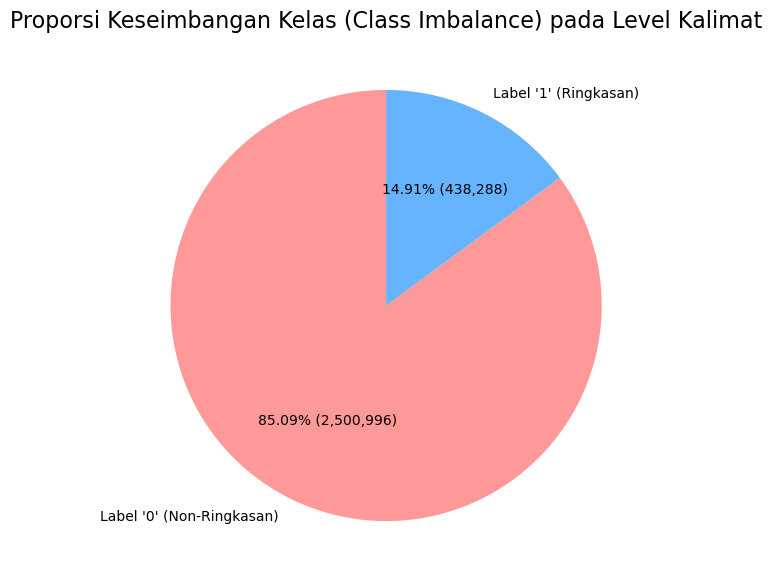

In [15]:
import pandas as pd
import ast
import nltk # Natural Language Toolkit untuk segmentasi kalimat
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan sudah mengunduh tokenizer 'punkt' untuk NLTK
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("Mengunduh tokenizer NLTK 'punkt_tab'...")
    nltk.download('punkt_tab')

# 1. Load Dataset
# Kita butuh 'clean_article' (untuk dihitung total kalimatnya)
# dan 'extractive_summary' (untuk dihitung kalimat positifnya)
print(f"Memuat dataset '{TRAIN_FILE}'...")
try:
    df_train = pd.read_csv(TRAIN_FILE, usecols=['clean_article', 'extractive_summary'])
    df_train = df_train.dropna()
    print(f"Dataset berhasil dimuat. Total entri: {len(df_train)}")

except FileNotFoundError:
    print(f"ERROR: File '{TRAIN_FILE}' tidak ditemukan.")
    df_train = pd.DataFrame(columns=['clean_article', 'extractive_summary'])
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")
    df_train = pd.DataFrame(columns=['clean_article', 'extractive_summary'])

if not df_train.empty:
    # 2. Proses Perhitungan Label
    print("Memulai perhitungan label kalimat...")
    
    total_positive_labels = 0
    total_negative_labels = 0
    total_sentences_corpus = 0

    # Iterasi per baris (per artikel)
    # Ini mungkin memakan waktu beberapa menit untuk 193rb data
    for index, row in df_train.iterrows():
        try:
            # 2a. Hitung total kalimat dalam artikel
            # nltk.sent_tokenize memecah artikel menjadi list kalimat
            sentences_in_article = nltk.sent_tokenize(row['clean_article'])
            num_total_sentences = len(sentences_in_article)
            
            # 2b. Hitung jumlah kalimat positif (yang jadi ringkasan)
            summary_indices = ast.literal_eval(row['extractive_summary'])
            num_positive_sentences = len(summary_indices)
            
            # 2c. Hitung jumlah kalimat negatif
            num_negative_sentences = num_total_sentences - num_positive_sentences
            
            # 2d. Akumulasi hitungan
            total_positive_labels += num_positive_sentences
            total_negative_labels += num_negative_sentences
            total_sentences_corpus += num_total_sentences

            if (index + 1) % 20000 == 0:
                print(f"  ... telah memproses {index + 1} artikel")

        except Exception as e:
            # Melewati baris yang mungkin formatnya rusak
            # print(f"Skipping row {index} due to error: {e}")
            continue

    print("Perhitungan label selesai.")

    # 3. Analisis Statistik
    if total_sentences_corpus > 0:
        ratio = total_negative_labels / total_positive_labels

        print("\n--- Statistik Keseimbangan Kelas (Level Kalimat) ---")
        print(f"Total Kalimat di Seluruh Dataset: {total_sentences_corpus}")
        print(f"Total Kalimat Label '1' (Ringkasan):   {total_positive_labels}")
        print(f"Total Kalimat Label '0' (Non-Ringkasan): {total_negative_labels}")
        print(f"Rasio ('0' : '1'):   {ratio:.2f} : 1")

        # 4. Visualisasi
        print("\nMembuat visualisasi...")
        
        # Data untuk plot
        labels_data = {
            'Label': ["Label '0' (Non-Ringkasan)", "Label '1' (Ringkasan)"],
            'Jumlah': [total_negative_labels, total_positive_labels]
        }
        df_plot = pd.DataFrame(labels_data)
        
        # Pie chart untuk menunjukkan proporsi
        plt.figure(figsize=(10, 7))
        plt.pie(
            df_plot['Jumlah'], 
            labels=df_plot['Label'], 
            autopct=lambda p: '{:.2f}% ({:,.0f})'.format(p, p * sum(df_plot['Jumlah']) / 100),
            startangle=90,
            colors=['#ff9999','#66b3ff']
        )
        plt.title('Proporsi Keseimbangan Kelas (Class Imbalance) pada Level Kalimat', fontsize=16)
        
        # Menyimpan plot
        plot_filename = 'eda_3_class_imbalance.png'
        plt.savefig(plot_filename)
        print(f"Visualisasi berhasil disimpan ke '{plot_filename}'")
        # plt.show() # Tampilkan plot di notebook

    else:
        print("Tidak ada data yang berhasil diproses.")

else:
    print("DataFrame kosong, analisis 'Class Imbalance' dibatalkan.")

# Text Quality and Segmentation Sentences Analysis

In [16]:
import pandas as pd
import nltk
import re # Modul Regular Expression untuk pembersihan

# Pastikan 'punkt' sudah terunduh
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# 1. Load Dataset
# Kita hanya perlu 'clean_article'
print(f"Memuat dataset '{TRAIN_FILE}' untuk sampling...")
try:
    df_train = pd.read_csv(TRAIN_FILE, usecols=['clean_article'])
    df_train = df_train.dropna()
    print("Dataset berhasil dimuat.")

except FileNotFoundError:
    print(f"ERROR: File '{TRAIN_FILE}' tidak ditemukan.")
    df_train = pd.DataFrame(columns=['clean_article'])
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")
    df_train = pd.DataFrame(columns=['clean_article'])


if not df_train.empty:
    # 2. Ambil 10-15 Sampel Acak
    # 'random_state' digunakan agar Anda bisa mendapatkan hasil yang sama
    # jika menjalankan ulang kode ini.
    sample_articles = df_train.sample(15, random_state=42)

    print("\n--- ANALISIS KUALITATIF SEGMENTASI KALIMAT (SAMPEL) ---")
    print("Perhatikan baik-baik apakah indeks [0] adalah 'boilerplate' (seperti 'Liputan6.com...')")
    print("dan apakah ada kesalahan pemenggalan kalimat.\n")
    
    # Fungsi pembersih boilerplate (JIKA DIPERLUKAN)
    # Ini adalah contoh, Anda bisa kustomisasi
    def simple_cleaner(text):
        # Pola ini mencari "Liputan6 . com , [Nama Kota] :"
        # \s* (spasi opsional), \. (titik), [^:]+ (teks apa saja sampai ketemu :)
        pattern = r"^\s*Liputan6\s*\.\s*com\s*,\s*[^:]+:\s*"
        # re.IGNORECASE membuat pola tidak case-sensitive
        cleaned_text = re.sub(pattern, "", text, count=1, flags=re.IGNORECASE)
        return cleaned_text.strip() # .strip() untuk hapus spasi sisa

    # 3. Iterasi dan Tampilkan Hasil Segmentasi
    for index, row in sample_articles.iterrows():
        print(f"========= ARTIKEL (Indeks Baris: {index}) ==========")
        original_text = row['clean_article']
        print(f"TEKS ASLI:\n{original_text[:200]}...\n") # Tampilkan 200 karakter pertama
        
        # --- Uji Coba 1: Segmentasi Langsung ---
        print("--- Hasil Segmentasi (Tanpa Cleaning) ---")
        sentences_raw = nltk.sent_tokenize(original_text)
        for i, sent in enumerate(sentences_raw[:3]): # Tampilkan 3 kalimat pertama
            print(f"  [{i}] {sent}")
        
        # --- Uji Coba 2: Segmentasi dengan Cleaning ---
        print("\n--- Hasil Segmentasi (Dengan Cleaning 'Liputan6.com...') ---")
        cleaned_text = simple_cleaner(original_text)
        sentences_cleaned = nltk.sent_tokenize(cleaned_text)
        for i, sent in enumerate(sentences_cleaned[:3]): # Tampilkan 3 kalimat pertama
            print(f"  [{i}] {sent}")
        
        print("=" * (50 + len(str(index))), "\n")

else:
    print("DataFrame kosong, analisis kualitatif dibatalkan.")

Memuat dataset 'E:\My Drive\Indonesia AI\2. Advanced NLP\Project 2\raw_data\liputan6_dataset_train.csv' untuk sampling...
Dataset berhasil dimuat.

--- ANALISIS KUALITATIF SEGMENTASI KALIMAT (SAMPEL) ---
Perhatikan baik-baik apakah indeks [0] adalah 'boilerplate' (seperti 'Liputan6.com...')
dan apakah ada kesalahan pemenggalan kalimat.

========= ARTIKEL (Indeks Baris: 42855) ==========
TEKS ASLI:
Liputan6 . com , Pandeglang : Sebuah ledakan keras terjadi di Kampung Ciruang , Desa Pejamben , Kecamatan Carita , Pandeglang , Banten , Selasa ( 1/7 ) , sekitar pukul 13 . 30 WIB . Pusat ledakan di s...

--- Hasil Segmentasi (Tanpa Cleaning) ---
  [0] Liputan6 .
  [1] com , Pandeglang : Sebuah ledakan keras terjadi di Kampung Ciruang , Desa Pejamben , Kecamatan Carita , Pandeglang , Banten , Selasa ( 1/7 ) , sekitar pukul 13 .
  [2] 30 WIB .

--- Hasil Segmentasi (Dengan Cleaning 'Liputan6.com...') ---
  [0] Sebuah ledakan keras terjadi di Kampung Ciruang , Desa Pejamben , Kecamatan Carita ,

# Length of Summary Analysis

Memuat dataset 'E:\My Drive\Indonesia AI\2. Advanced NLP\Project 2\raw_data\liputan6_dataset_train.csv'... (hanya kolom 'extractive_summary')
Dataset berhasil dimuat. Total entri: 193883
Menghitung jumlah kalimat di setiap ringkasan...
Perhitungan selesai.

--- Statistik Panjang Ringkasan (Jumlah Kalimat) ---
summary_length
1          4
2     153503
3      32972
4       5576
5       1217
6        393
7        155
8         48
9          9
10         3
11         2
13         1
Name: count, dtype: int64

Membuat visualisasi...
Visualisasi berhasil disimpan ke 'eda_5_summary_length_distribution.png'


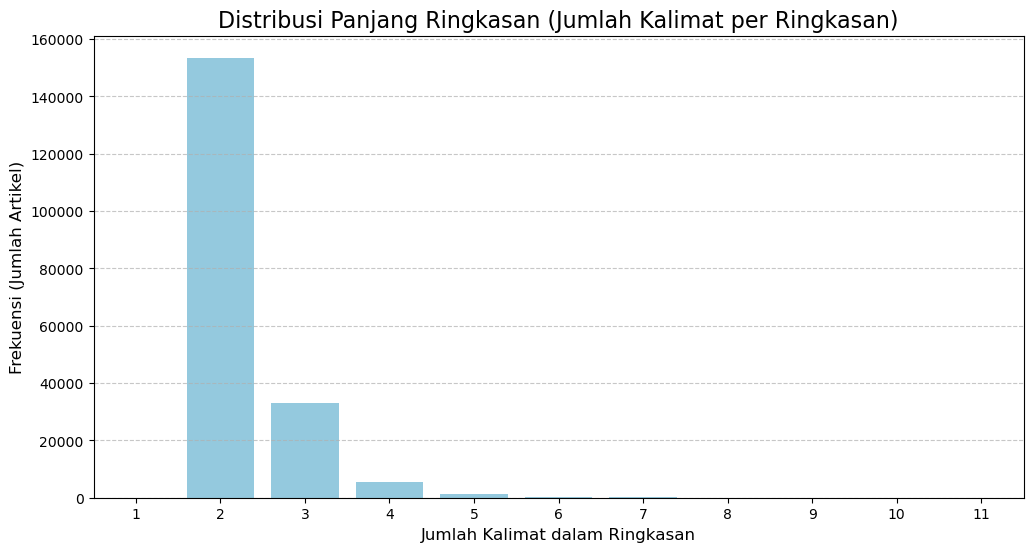

In [17]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Dataset
# Kita hanya butuh kolom 'extractive_summary'
print(f"Memuat dataset '{TRAIN_FILE}'... (hanya kolom 'extractive_summary')")
try:
    df_train = pd.read_csv(TRAIN_FILE, usecols=['extractive_summary'])
    df_train = df_train.dropna(subset=['extractive_summary'])
    print(f"Dataset berhasil dimuat. Total entri: {len(df_train)}")

except FileNotFoundError:
    print(f"ERROR: File '{TRAIN_FILE}' tidak ditemukan.")
    df_train = pd.DataFrame(columns=['extractive_summary'])
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")
    df_train = pd.DataFrame(columns=['extractive_summary'])

if not df_train.empty:
    # 2. Hitung Panjang Ringkasan (Jumlah Kalimat)
    print("Menghitung jumlah kalimat di setiap ringkasan...")
    
    # Fungsi untuk menghitung panjang list dari string
    def get_summary_length(summary_str):
        try:
            indices = ast.literal_eval(summary_str)
            if isinstance(indices, list):
                return len(indices)
        except (ValueError, SyntaxError):
            pass # Abaikan format yang rusak
        return None

    # Buat kolom baru 'summary_length'
    df_train['summary_length'] = df_train['extractive_summary'].apply(get_summary_length)
    
    # Hapus baris yang gagal di-parse
    df_train = df_train.dropna(subset=['summary_length'])
    df_train['summary_length'] = df_train['summary_length'].astype(int)

    print("Perhitungan selesai.")

    # 3. Analisis Statistik dan Visualisasi
    print("\n--- Statistik Panjang Ringkasan (Jumlah Kalimat) ---")
    # Menghitung frekuensi kemunculan setiap panjang
    summary_length_counts = df_train['summary_length'].value_counts().sort_index()
    print(summary_length_counts)

    print("\nMembuat visualisasi...")
    plt.figure(figsize=(12, 6))
    
    # Menggunakan countplot untuk melihat distribusi diskrit (1, 2, 3, 4, ... kalimat)
    sns.countplot(
        data=df_train, 
        x='summary_length', 
        color='skyblue',
        order=summary_length_counts.index # Urutkan berdasarkan jumlah kalimat
    )
    
    plt.title('Distribusi Panjang Ringkasan (Jumlah Kalimat per Ringkasan)', fontsize=16)
    plt.xlabel('Jumlah Kalimat dalam Ringkasan', fontsize=12)
    plt.ylabel('Frekuensi (Jumlah Artikel)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Atur batas x-axis agar lebih mudah dibaca (misal, 0 s/d 10)
    # Anda bisa sesuaikan ini berdasarkan output statistik Anda
    plt.xlim(-0.5, 10.5) 

    # Menyimpan plot
    plot_filename = 'eda_5_summary_length_distribution.png'
    plt.savefig(plot_filename)
    print(f"Visualisasi berhasil disimpan ke '{plot_filename}'")
    # plt.show() # Tampilkan plot di notebook

else:
    print("DataFrame kosong, analisis 'Panjang Ringkasan' dibatalkan.")